# Classifier

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("union_allfeat_df_allcomments.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402 entries, -BlitzN9ne to zymmaster
Columns: 13195 entries, ('text', 'body') to ('lda', 'ldahundred')
dtypes: float64(5102), int64(8083), object(10)
memory usage: 40.5+ MB


In [ ]:
# level 0 column names
predictors = df.columns
featurelst = []
for i in range(len(predictors)):
    featurelst.append(predictors[i][0])
featureset = set(featurelst)
print(featureset)

In [ ]:
# create smaller dfs
log_wordngrams_df = df[['trait', 'wordngram']]
log_charngrams_df = df[['trait', 'charngram']]
log_wordlists_df =  df[['trait', 'x_feat', 'lin_feat', 'psych', 'empath']]
# log_posts_df = df[['trait', 'post', 'time', 'subreddit', 'lda']]
# log_postswithoutsubreddits_df = df[['trait', 'post', 'time', 'lda']]
log_posts_df = df[['trait', 'post', 'subtf', 'lda']]
log_postswithoutsubreddits_df = df[['trait', 'post', 'subtf', 'lda']]

In [ ]:
# # separate word ngrams
# droplst = []
# index = 17124
# for i in range(1000):
#     index = index+1
#     droplst.append(predictors[index][1])

# log_wordngrams_df = log_wordngrams_df.drop(droplst, axis=1, level=1)

In [ ]:
# # separate char ngrams
# worddroplst = []
# wordindex = 16125
# for i in range(1000):
#     wordindex = wordindex+1
#     worddroplst.append(predictors[wordindex][1])

# log_charngrams_df = log_charngrams_df.drop(worddroplst, axis=1, level=1)

In [ ]:
def all_hist_true(df):
    plt.figure(figsize = (16, 16))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(3, 2, 1)
    plt.hist(df['trait', 'openness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(3, 2, 2)
    plt.hist(df['trait', 'conscientiousness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(3, 2, 3)
    plt.hist(df['trait', 'extraversion'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(3, 2, 4)
    plt.hist(df['trait', 'agreeableness'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(3, 2, 5)
    plt.hist(df['trait', 'neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()

## Trait

In [3]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name):
    featuredf = df.drop(['data', 'trait', 'text'], axis=1, level=0)
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if classes=='binary':
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_o']
        elif trait_name == 'openness':
            y = df['trait', 'big5_c']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_e']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_a']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n']   
    elif classes=='multi':
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_o_multi']
        elif trait_name == 'openness':
            y = df['trait', 'big5_c_multi']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_e_multi']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_a_multi']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n_multi'] 
    elif classes=='linear':
        if trait_name == 'agreeableness':
            y = df['trait', 'agreeableness']
        elif trait_name == 'openness':
            y = df['trait', 'openness']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'conscientiousness']
        elif trait_name == 'extraversion':
            y = df['trait', 'extraversion']
        elif trait_name == 'neuroticism':
            y = df['trait', 'neuroticism']  
    elif classes=='mbti':
        if trait_name == 'mbti_ei':
            y = df['trait', 'mbti_ei']
        elif trait_name == 'mbti_ns':
            y = df['trait', 'mbti_ns']
        elif trait_name == 'mbti_tf':
            y = df['trait', 'mbti_tf']
        elif trait_name == 'mbti_jp':
            y = df['trait', 'mbti_jp'] 
    return x,y 

## Classifier

## Get names of 30 most important features

In [4]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

### Get p-values

In [ ]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

## Scores

In [ ]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    
    return lr_precision, lr_recall

### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [ ]:
def create_cnfmatrix(clf, x_test, y_test, y_pred, plotting, detailed):
    cnfpipe_matrix = confusion_matrix(y_test, y_pred)

    if detailed:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sumpositive = tp + fn
        sumnegative = fp + tn
        sumcorrect = tp + tn
        sumwrong = fp + fn
        sumall = tn+fp+fn+tp
        print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
              sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
              sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
              "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)

    if plotting:
        plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()


## ROC Curve

In [ ]:
def roc_aucscore(clf, x_test, y_test, classes, plotting, detailed):
    if detailed:
        print(roc_auc_score(y, clf.predict_proba(x), multi_class='ovo'))
        return score
    
    if plotting and classes == 'binary':
        plot_roc_curve(clf, x_test, y_test)
        plt.title('ROC Curve', y=1.1)
        plt.show()

## Wrapper with nested stratified cross validation

In [5]:
def get_classifier(classifier):
    if classifier == 'log':
        return LogisticRegression(class_weight='balanced', n_jobs=-1)
    elif classifier == 'mcc':
        return DummyClassifier(strategy="most_frequent")
    elif classifier == 'mlp':
        return MLPClassifier()
    elif classifier == 'svm':
        return svm.SVC(class_weight='balanced', probability=True)
    elif classifier == 'linear':
        return LinearRegression(n_jobs=-1)
    elif classifier == 'multilog':
        return LogisticRegression(multi_class='multinomial', n_jobs=-1)
    elif classifier == 'knn':
        return KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

    
def get_featureselection(fs, classifier, n_feat):
    if fs == 'anova':
        return SelectKBest(f_classif, k=n_feat)
    if fs == 'mutual':
        return SelectKBest(mutual_info_classif, k=n_feat)
    if fs == 'sequential_forward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='forward', n_jobs=-1)
    if fs == 'sequential_backward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='backward', n_jobs=-1)


    
def create_pipeline_cv(classifier, fs, dim, n_feat):
    if dim:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('pca', PCA(n_components=100)),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    else:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    return pipeline

In [8]:
def get_params(classifier):
    if classifier == 'log':
        params = {'classification__solver': ['lbfgs', 'liblinear', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    if classifier == 'multilog':
        params = {'classification__class_weight': [None, 'balanced'], 
                  'classification__solver': ['lbfgs', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000]}
    elif classifier == 'mlp':
        params = {'classification__hidden_layer_sizes': [(50,), (100,), (200,), (500,)]}
    elif classifier == 'svm':
        params = {'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'classification__gamma': ['scale', 'auto'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    elif classifier == 'mcc':
        params = {}
    return params

def classify_cv(df, traits, classes, clf_lst, fs, dim, n_feat):
    tstart = time()
    for option in tqdm(clf_lst):
        print("Classifier: ", option, "\n")
        for trait_name in traits:
            print("\nTrait to predict: ", trait_name, "\n")
            x,y = trait(df, classes, trait_name)          
            
            cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
            cv_outer_lst = cv_outer.split(x, y)

            f1macro_lst = []
            accuracy_lst = []
            tpr_lst = []
            mean_fpr = np.linspace(0, 1, 101)
            
            plt.figure(figsize=(5, 5))
            j=1
            for train_idx, val_idx in cv_outer_lst:
                train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
                train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]

                print("\nCreate pipeline with", option, "(Fold", j,"), for trait: ", trait_name, "...\n")
                clf = create_pipeline_cv(option, fs, dim, n_feat)
                if option == 'log':
                    cv_inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
                if option == 'svm' or option == 'mlp' or option == 'mcc':
                    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
                params = get_params(option)
                t0 = time()
                gd_search = GridSearchCV(clf, params, scoring = 'f1_macro', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
                print("Grid search done in %0.2fs" % (time() - t0))
                best_model = gd_search.best_estimator_
                names = get_names(train_data, best_model)
                print("Selected features: ", list(names))

                clfnew = best_model.fit(train_data, train_target)
                y_pred = clfnew.predict(val_data)
                y_score = clfnew.predict_proba(val_data)
                fpr, tpr, _ = roc_curve(val_target, y_score[:, 1])

                plt.plot(fpr, tpr, 'b', alpha=0.15)
                tpr = np.interp(mean_fpr, fpr, tpr)
                tpr[0] = 0.0
                tpr_lst.append(tpr)
                
                f1_macro = f1_score(val_target, y_pred, average='macro')
                f1macro_lst.append(f1_macro)
                acc = accuracy_score(val_target, y_pred)
                accuracy_lst.append(acc)
                print("\tVal Accuracy: ", acc, "Val F1-score:", f1_macro , 
                      "Best GS F1-score:",gd_search.best_score_, "\nBest Params:",gd_search.best_params_)
                j+=1
              # Training final model
            f1macro_avg = np.mean(f1macro_lst)
            acc_avg = np.mean(accuracy_lst)
            print("\n\nAverage f1 macro score: ", f1macro_avg)
            print("Average accuracy: ", acc_avg)
            print("Time for entire process: %0.2fs" % (time() - tstart))
            
            tprs = np.array(tpr_lst)
            mean_tprs = tprs.mean(axis=0)
            std = tprs.std(axis=0)
            tprs_upper = np.minimum(mean_tprs + std, 1)
            tprs_lower = mean_tprs - std

            plt.plot(mean_fpr, mean_tprs, 'b')
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([-0.01, 1.01])
            plt.ylim([-0.01, 1.01])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.axes().set_aspect('equal', 'datalim')
            plt.show()

big5_traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
mbti_traits =['mbti_ei', 'mbti_ns', 'mbti_tf', 'mbti_jp']

## Methodological replication

In [ ]:
clf_lst = ['mcc', 'log', 'mlp', 'svm']
classify_cv(df, big5_traits, 'binary', clf_lst, 'anova', dim=False, n_feat=30)

  0%|          | 0/1 [00:00<?, ?it/s]

Classifier:  log 


Trait to predict:  openness 


Create pipeline with log (Fold 1 ), for trait:  openness ...

Grid search done in 52.88s
Selected features:  [('subtf', 'medicalgore'), ('subtf', 'silhouwhat'), ('subtf', 'forgeofempires'), ('subtf', 'broodwar'), ('wordngram', 'also not'), ('wordngram', 'dnc'), ('wordngram', 'ed'), ('wordngram', 'gif'), ('wordngram', 'good point'), ('wordngram', 'hard'), ('wordngram', 'joke'), ('wordngram', 'know'), ('wordngram', 'mayb not'), ('wordngram', 'realli care'), ('wordngram', 'share'), ('wordngram', 'socialist'), ('wordngram', 'whole'), ('wordngram', 'whole thing'), ('charngram', 'ama'), ('charngram', 'ayb'), ('charngram', 'bet_char'), ('charngram', 'eed'), ('charngram', 'eme'), ('charngram', 'gn'), ('charngram', 'ini'), ('charngram', 'nec'), ('charngram', 'nex'), ('charngram', 'nli'), ('charngram', 'nou'), ('charngram', 'now')]
	Val Accuracy:  0.5432098765432098 Val F1-score: 0.5406896551724139 Best GS F1-score: 0.5226246166365573 
Best Para

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Grid search done in 50.91s
Selected features:  [('subtf', 'transhuman'), ('subtf', 'nintendoswitch'), ('subtf', 'babybigcatgifs'), ('subtf', 'sexandthecity'), ('subtf', 'languagebuds'), ('subtf', 'nsfwfunny'), ('subtf', 'clonazoland'), ('wordngram', 'analysi'), ('wordngram', 'anyhow'), ('wordngram', 'cash'), ('wordngram', 'cloth'), ('wordngram', 'difficulti'), ('wordngram', 'femal'), ('wordngram', 'harder'), ('wordngram', 'justifi'), ('wordngram', 'one person'), ('wordngram', 'reader'), ('wordngram', 'tini'), ('wordngram', 'tip'), ('wordngram', 'twice'), ('wordngram', 'would make'), ('wordngram', 'youtu'), ('charngram', ' de'), ('charngram', ' of'), ('charngram', 'ee'), ('charngram', 'l b'), ('charngram', 'l m'), ('charngram', 'lat'), ('charngram', 'lea'), ('charngram', 'lec')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Val Accuracy:  0.5679012345679012 Val F1-score: 0.5503568596352101 Best GS F1-score: 0.5420732987757112 
Best Params: {'classification__C': 0.1, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

Create pipeline with log (Fold 3 ), for trait:  openness ...

Grid search done in 51.17s
Selected features:  [('subtf', 'undertale'), ('subtf', 'starwarsepisodeviii'), ('subtf', 'whatwasyourredpill'), ('subtf', 'programmerreactions'), ('subtf', 'waterniggas'), ('wordngram', 'assum'), ('wordngram', 'bird'), ('wordngram', 'fals'), ('wordngram', 'health'), ('wordngram', 'oper'), ('wordngram', 'platform'), ('wordngram', 'program'), ('wordngram', 'realli enjoy'), ('wordngram', 'sure'), ('wordngram', 'tag'), ('wordngram', 'throw'), ('wordngram', 'ton'), ('wordngram', 'tone'), ('wordngram', 'west'), ('wordngram', 'word'), ('charngram', ' ad'), ('charngram', ' em'), ('charngram', 'an '), ('charngram', 'c c'), ('charngram', 'g b'), ('charngram', 'h r'), ('charngram', 'h s'), ('ch

<ipython-input-8-59ea1dbf0eea>:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


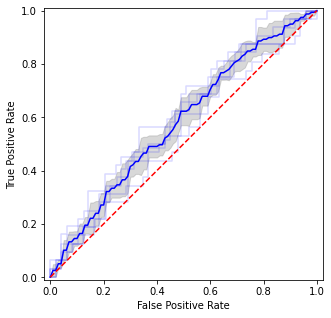


Trait to predict:  conscientiousness 


Create pipeline with log (Fold 1 ), for trait:  conscientiousness ...



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Grid search done in 50.49s
Selected features:  [('subtf', 'dota2'), ('subtf', 'harmontown'), ('subtf', 'rifftrax'), ('subtf', 'oldschool'), ('subtf', 'beetlejuicing'), ('subtf', 'bottlecapcollecting'), ('subtf', 'davidbowie'), ('subtf', 'forgeofempires'), ('subtf', 'linuxcirclejerk'), ('wordngram', 'advertis'), ('wordngram', 'beta'), ('wordngram', 'cognit function'), ('wordngram', 'coin'), ('wordngram', 'explain'), ('wordngram', 'long not'), ('wordngram', 'mani'), ('wordngram', 'miss'), ('wordngram', 'not thing'), ('wordngram', 'person would'), ('wordngram', 'present'), ('wordngram', 'privat'), ('wordngram', 'regularli'), ('wordngram', 'situat'), ('wordngram', 'told'), ('charngram', ' to'), ('charngram', 'abi'), ('charngram', 'ead'), ('charngram', 'eak'), ('charngram', 'eam'), ('charngram', 'h w')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Val Accuracy:  0.6790123456790124 Val F1-score: 0.6452156334231806 Best GS F1-score: 0.5748673931831826 
Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

Create pipeline with log (Fold 2 ), for trait:  conscientiousness ...



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Grid search done in 50.60s
Selected features:  [('subtf', 'secularbuddhism'), ('subtf', 'pbsideachannel'), ('subtf', 'whatsthisrock'), ('subtf', 'descentintotyranny'), ('subtf', 'cyclistswithcameras'), ('subtf', 'burningman'), ('subtf', 'asoiaf'), ('subtf', 'latestagecarnism'), ('wordngram', 'alpha'), ('wordngram', 'ancap'), ('wordngram', 'applic'), ('wordngram', 'buy'), ('wordngram', 'ca'), ('wordngram', 'client'), ('wordngram', 'cop'), ('wordngram', 'downvot'), ('wordngram', 'plant'), ('wordngram', 'post not'), ('wordngram', 'precis'), ('wordngram', 'psycholog'), ('wordngram', 'public'), ('wordngram', 'rare'), ('charngram', 'ama'), ('charngram', 'as '), ('charngram', 'bab'), ('charngram', 'eft'), ('charngram', 'exc'), ('charngram', 'i m'), ('charngram', 'les'), ('charngram', 'lle')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Val Accuracy:  0.6790123456790124 Val F1-score: 0.6603225806451614 Best GS F1-score: 0.6307256759786262 
Best Params: {'classification__C': 10, 'classification__max_iter': 100, 'classification__solver': 'saga'}

Create pipeline with log (Fold 3 ), for trait:  conscientiousness ...

Grid search done in 50.85s
Selected features:  [('subtf', 'askengineers'), ('subtf', 'goruck'), ('subtf', 'leica'), ('subtf', 'wedding'), ('subtf', 'adhd_programmers'), ('subtf', 'futurecirclejerk'), ('subtf', 'starwarscomics'), ('subtf', 'meemyselfandi'), ('subtf', 'mid_century'), ('wordngram', 'afraid'), ('wordngram', 'agre'), ('wordngram', 'anymor'), ('wordngram', 'app'), ('wordngram', 'bs'), ('wordngram', 'key'), ('wordngram', 'per'), ('wordngram', 'philosophi'), ('wordngram', 'profession'), ('wordngram', 'quick'), ('wordngram', 'trait'), ('wordngram', 'twice'), ('wordngram', 'typolog'), ('charngram', 'awa'), ('charngram', 'ed_char'), ('charngram', 'eon'), ('charngram', 'ht '), ('charngram', 'ifi'), ('c

<ipython-input-8-59ea1dbf0eea>:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


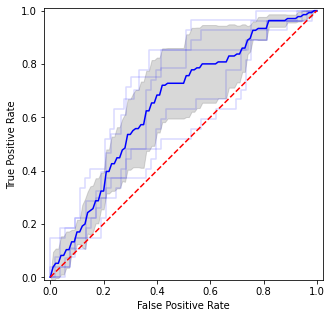


Trait to predict:  extraversion 


Create pipeline with log (Fold 1 ), for trait:  extraversion ...

Grid search done in 49.70s
Selected features:  [('subtf', 'yikyak'), ('subtf', 'marriage'), ('wordngram', 'age'), ('wordngram', 'also like'), ('wordngram', 'anybodi'), ('wordngram', 'asian'), ('wordngram', 'awhil'), ('wordngram', 'back'), ('wordngram', 'code'), ('wordngram', 'dark'), ('wordngram', 'like type mention'), ('wordngram', 'lol'), ('wordngram', 'market'), ('wordngram', 'nois'), ('wordngram', 'plan'), ('wordngram', 'stand'), ('wordngram', 'still not'), ('wordngram', 'straight'), ('wordngram', 'teacher'), ('wordngram', 'that'), ('wordngram', 'thing go'), ('wordngram', 'trash'), ('wordngram', 'visit'), ('wordngram', 'yup'), ('wordngram', 'zero'), ('charngram', ' pe'), ('charngram', ' sa'), ('charngram', ' tr'), ('charngram', 'ac'), ('charngram', 'ird')]
	Val Accuracy:  0.6049382716049383 Val F1-score: 0.5999999999999999 Best GS F1-score: 0.6362618305617541 
Best Params: {'classi

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Grid search done in 49.82s
Selected features:  [('subtf', 'vaguns'), ('subtf', 'pebble'), ('wordngram', 'assert'), ('wordngram', 'aw'), ('wordngram', 'bitch'), ('wordngram', 'bright'), ('wordngram', 'broad'), ('wordngram', 'could get'), ('wordngram', 'environ'), ('wordngram', 'even though'), ('wordngram', 'hand'), ('wordngram', 'movement'), ('wordngram', 'publish'), ('wordngram', 'regard'), ('wordngram', 'regret'), ('wordngram', 'st'), ('wordngram', 'talk'), ('wordngram', 'test'), ('wordngram', 'virtu'), ('wordngram', 'would also'), ('charngram', ' n'), ('charngram', ' ne'), ('charngram', ' ni'), ('charngram', 'ait'), ('charngram', 'am'), ('charngram', 'ap'), ('charngram', 'av'), ('charngram', 'h t'), ('charngram', 'lf'), ('charngram', 'lim')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Val Accuracy:  0.725 Val F1-score: 0.7206349206349206 Best GS F1-score: 0.606005714566513 
Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

Create pipeline with log (Fold 5 ), for trait:  extraversion ...

Grid search done in 50.23s
Selected features:  [('subtf', 'chakras'), ('wordngram', 'answer'), ('wordngram', 'bare'), ('wordngram', 'came'), ('wordngram', 'cat'), ('wordngram', 'cogfunc mention cogfunc'), ('wordngram', 'complet'), ('wordngram', 'confus'), ('wordngram', 'destruct'), ('wordngram', 'driven'), ('wordngram', 'drunk'), ('wordngram', 'not feel'), ('wordngram', 'sad'), ('wordngram', 'scientif'), ('wordngram', 'type mention type'), ('wordngram', 'univers'), ('wordngram', 'wikipedia org'), ('charngram', ' nu'), ('charngram', ' ob'), ('charngram', 'ar'), ('charngram', 'ara'), ('charngram', 'arc'), ('charngram', 'ch'), ('charngram', 'cla'), ('charngram', 'cti'), ('charngram', 'eli'), ('charngram', 'ery'), ('charn

<ipython-input-8-59ea1dbf0eea>:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


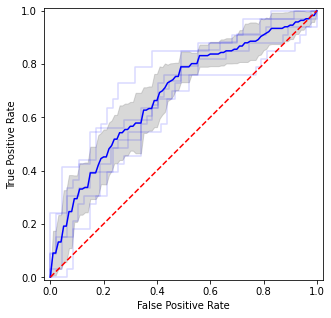


Trait to predict:  agreeableness 


Create pipeline with log (Fold 1 ), for trait:  agreeableness ...

Grid search done in 49.70s
Selected features:  [('subtf', 'ptcgo'), ('subtf', 'benhoward'), ('subtf', 'rifftrax'), ('subtf', 'mobilewallpaper'), ('subtf', 'darknetmarkets'), ('subtf', 'algotrading'), ('wordngram', 'bibl'), ('wordngram', 'confid'), ('wordngram', 'dont'), ('wordngram', 'explain'), ('wordngram', 'farm'), ('wordngram', 'flaw'), ('wordngram', 'hole'), ('wordngram', 'ie'), ('wordngram', 'latter'), ('wordngram', 'libertarian'), ('wordngram', 'no not'), ('wordngram', 'not trust'), ('wordngram', 'opposit'), ('wordngram', 'plot'), ('wordngram', 'pro'), ('wordngram', 'realli know'), ('wordngram', 'si'), ('wordngram', 'updat'), ('charngram', 'alt_char'), ('charngram', 'are'), ('charngram', 'ee '), ('charngram', 'emp'), ('charngram', 'hil'), ('charngram', 'lv')]
	Val Accuracy:  0.6296296296296297 Val F1-score: 0.48429541595925296 Best GS F1-score: 0.5061633505371803 
Best Params:

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Grid search done in 49.54s
Selected features:  [('subtf', 'talesfromyourserver'), ('subtf', 'redditdev'), ('subtf', 'foundfelix'), ('subtf', 'duckduckgo'), ('subtf', 'zerocarb'), ('subtf', 'soundslikemusic'), ('subtf', 'xanax'), ('subtf', 'marshmello'), ('subtf', 'horriblydepressing'), ('subtf', 'riverdale'), ('subtf', 'milliondollarextreme'), ('subtf', 'circle'), ('wordngram', 'adopt'), ('wordngram', 'anywher'), ('wordngram', 'biggest'), ('wordngram', 'concept'), ('wordngram', 'download'), ('wordngram', 'hair'), ('wordngram', 'hint'), ('wordngram', 'long term'), ('wordngram', 'mistyp'), ('wordngram', 'not consid'), ('wordngram', 'not stand'), ('wordngram', 'presid presid presid'), ('wordngram', 'react'), ('wordngram', 'risk'), ('charngram', 'ans'), ('charngram', 'e c'), ('charngram', 'e d'), ('charngram', 'guy_char')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Val Accuracy:  0.5375 Val F1-score: 0.44266616456411223 Best GS F1-score: 0.62150767041946 
Best Params: {'classification__C': 1, 'classification__max_iter': 100, 'classification__solver': 'saga'}

Create pipeline with log (Fold 5 ), for trait:  agreeableness ...



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Grid search done in 50.03s
Selected features:  [('subtf', 'army'), ('subtf', 'theonwinsthethrone'), ('subtf', 'thedivision'), ('subtf', 'seaglass'), ('subtf', 'procomputertips'), ('subtf', 'notebooks'), ('subtf', 'gaysgonewild'), ('subtf', 'shen'), ('subtf', 'teenagers'), ('subtf', 'breadtube'), ('subtf', 'topgear'), ('subtf', 'bulletjournal'), ('subtf', 'combinedgifs'), ('wordngram', 'argument'), ('wordngram', 'birth'), ('wordngram', 'cognit function'), ('wordngram', 'conserv'), ('wordngram', 'consid'), ('wordngram', 'deliv'), ('wordngram', 'ill'), ('wordngram', 'partner'), ('wordngram', 'ridicul'), ('wordngram', 'sorri'), ('wordngram', 'transfer'), ('charngram', 'd e'), ('charngram', 'hoo'), ('charngram', 'hop'), ('charngram', 'is'), ('charngram', 'is '), ('charngram', 'lo')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
<ipython-input-8-59ea1dbf0eea>:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


	Val Accuracy:  0.5875 Val F1-score: 0.5146166574738004 Best GS F1-score: 0.5246305060311467 
Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}


Average f1 macro score:  0.497976097552399
Average accuracy:  0.6166358024691359
Time for entire process: 1014.18s


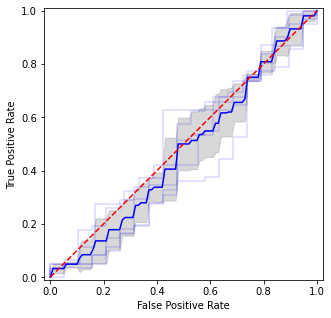


Trait to predict:  neuroticism 


Create pipeline with log (Fold 1 ), for trait:  neuroticism ...

Grid search done in 50.12s
Selected features:  [('subtf', 'in_a_nutshell'), ('subtf', 'emmawatson'), ('subtf', 'lolesports'), ('subtf', 'baskets'), ('subtf', 'insanepeoplefacebook'), ('wordngram', 'alpha'), ('wordngram', 'alreadi'), ('wordngram', 'british'), ('wordngram', 'could see'), ('wordngram', 'element'), ('wordngram', 'even know'), ('wordngram', 'fail'), ('wordngram', 'not pay'), ('wordngram', 'quit bit'), ('wordngram', 'reliabl'), ('wordngram', 'row'), ('wordngram', 'stock'), ('wordngram', 'weight'), ('wordngram', 'would say'), ('charngram', ' ht'), ('charngram', ' hu'), ('charngram', 'ay'), ('charngram', 'ay '), ('charngram', 'd m'), ('charngram', 'hy'), ('charngram', 'ird'), ('charngram', 'ka'), ('charngram', 'ma'), ('charngram', 'n p'), ('charngram', 'n y')]
	Val Accuracy:  0.5432098765432098 Val F1-score: 0.5291437549096621 Best GS F1-score: 0.6424870633687447 
Best Params: {

/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Grid search done in 50.25s
Selected features:  [('subtf', 'netflix'), ('subtf', 'rad_decentralization'), ('subtf', 'openttd'), ('subtf', 'ucalgary'), ('subtf', 'checkmylogic'), ('subtf', 'eq2'), ('wordngram', 'ah'), ('wordngram', 'appreci'), ('wordngram', 'arrest'), ('wordngram', 'arriv'), ('wordngram', 'fals'), ('wordngram', 'finish'), ('wordngram', 'invest'), ('wordngram', 'like not'), ('wordngram', 'meaningless'), ('wordngram', 'oh god'), ('wordngram', 'op'), ('wordngram', 'phone'), ('wordngram', 'sacrific'), ('wordngram', 'ta'), ('wordngram', 'unless'), ('wordngram', 'wear'), ('charngram', 'cau'), ('charngram', 'e p'), ('charngram', 'g m'), ('charngram', 'h l'), ('charngram', 'lin'), ('charngram', 'n u'), ('charngram', 'na_char'), ('charngram', 'nst')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


	Val Accuracy:  0.6790123456790124 Val F1-score: 0.675 Best GS F1-score: 0.548200533148506 
Best Params: {'classification__C': 1, 'classification__max_iter': 200, 'classification__solver': 'saga'}

Create pipeline with log (Fold 3 ), for trait:  neuroticism ...



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Grid search done in 49.09s
Selected features:  [('subtf', 'budgetaudiophile'), ('subtf', 'trollxfunny'), ('subtf', 'instlife'), ('subtf', 'izlam'), ('subtf', 'adporn'), ('subtf', 'wellington'), ('subtf', 'oneplus'), ('subtf', 'watchpeopledie'), ('subtf', 'hollowknight'), ('subtf', 'jetprogramme'), ('wordngram', 'casual'), ('wordngram', 'club'), ('wordngram', 'infinit'), ('wordngram', 'later'), ('wordngram', 'latter'), ('wordngram', 'month'), ('wordngram', 'not talk'), ('wordngram', 'send'), ('wordngram', 'smile'), ('wordngram', 'typic'), ('wordngram', 'white'), ('wordngram', 'word'), ('charngram', 'ach'), ('charngram', 'ah_char'), ('charngram', 'cto'), ('charngram', 'em '), ('charngram', 'g l'), ('charngram', 'g r'), ('charngram', 'h v'), ('charngram', 'hat_char')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Val Accuracy:  0.5875 Val F1-score: 0.5724696356275304 Best GS F1-score: 0.591844681481776 
Best Params: {'classification__C': 0.01, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

Create pipeline with log (Fold 4 ), for trait:  neuroticism ...



/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Grid search done in 49.27s
Selected features:  [('subtf', 'callofcthulhu'), ('subtf', 'superhot'), ('subtf', 'warhammer'), ('subtf', 'nononsensembti'), ('subtf', 'compsci'), ('subtf', 'vent'), ('subtf', 'veganketo'), ('subtf', 'historywhatif'), ('subtf', 'okbuddyretard'), ('subtf', 'badwomensanatomy'), ('subtf', 'insomnia'), ('subtf', 'ancientgreece'), ('subtf', 'broslikeus'), ('wordngram', 'along'), ('wordngram', 'autism'), ('wordngram', 'awar'), ('wordngram', 'bottom'), ('wordngram', 'can'), ('wordngram', 'career'), ('wordngram', 'feet'), ('wordngram', 'ish'), ('wordngram', 'much time'), ('wordngram', 'not big'), ('wordngram', 'remain'), ('wordngram', 'want not'), ('charngram', ' r'), ('charngram', 'e l'), ('charngram', 'ev'), ('charngram', 'ew'), ('charngram', 'g d')]


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


	Val Accuracy:  0.6125 Val F1-score: 0.6019900497512438 Best GS F1-score: 0.5929108680316721 
Best Params: {'classification__C': 0.001, 'classification__max_iter': 100, 'classification__solver': 'liblinear'}

Create pipeline with log (Fold 5 ), for trait:  neuroticism ...

Grid search done in 49.24s
Selected features:  [('subtf', 'dungeonlink'), ('subtf', 'surrealmemes'), ('subtf', 'enemystands'), ('subtf', 'starterpacks'), ('subtf', 'pykemains'), ('subtf', 'gallifrey'), ('subtf', 'paydaytheheist'), ('subtf', 'soulssliders'), ('subtf', 'ehlersdanlos'), ('subtf', 'hackintosh'), ('wordngram', 'amp amp'), ('wordngram', 'basic'), ('wordngram', 'cheap'), ('wordngram', 'crime'), ('wordngram', 'destroy'), ('wordngram', 'disappoint'), ('wordngram', 'entitl'), ('wordngram', 'everyon'), ('wordngram', 'instantli'), ('wordngram', 'involv'), ('wordngram', 'neutral'), ('wordngram', 'never'), ('wordngram', 'not use'), ('wordngram', 'punch'), ('wordngram', 'tower'), ('charngram', 'efi'), ('charngram',

<ipython-input-8-59ea1dbf0eea>:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


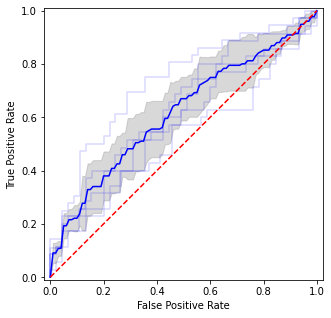

In [9]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=30)

In [ ]:
classify_cv(df, mbti_traits, 'mbti', ['log'], 'anova', dim=False, n_feat=30)

In [ ]:
print("Logistic regression with subsets of the features")
print("LR with word ngrams")
classify_cv(log_wordngrams_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with char ngrams")
classify_cv(log_charngrams_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with wordlists")
classify_cv(log_wordlists_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with posts features")
classify_cv(log_posts_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with posts features but without subreddit")
classify_cv(log_postswithoutsubreddits_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

## New approach

In [ ]:
print("LR with mutual info feature selection")
classify_cv(df, 'binary', ['log'], 'mutual', dim=False)

In [ ]:
print("LR with sequential feature selection and pca")
classify_cv(df, 'binary', ['log'], 'sequential', dim=True´´´´´´´´´´´´´´´´´)

## Histogram of true traits

In [ ]:
def check_imbalance(df, traits):
    length = len(df)
    o = df['trait', 'big5_o']
    c = df['trait', 'big5_c']
    e = df['trait', 'big5_e']
    a = df['trait', 'big5_a']
    n = df['trait', 'big5_n']
    binarylst = [o, c, e, a, n]
    o5 = df['trait', 'big5_o_multi']
    c5 = df['trait', 'big5_c_multi']
    e5 = df['trait', 'big5_e_multi']
    a5 = df['trait', 'big5_a_multi']
    n5 = df['trait', 'big5_n_multi']
    multilst = [o5, c5, e5, a5, n5]
    
    result = []
    for trait in binarylst: 
        result.append(np.bincount(trait) / length)
    result5 = []
    for trait in multilst:
        result5.append(np.bincount(trait) / len(trait))
    
    print("Distribution of the true trait values in the classes (in %):\n")
    for i in range(len(traits)):
        print(traits[i], "\n\tBinary: ", result[i], "\n\t5 classes: ", result5[i], "\n")
    
#     result =np.bincount(o) / len(o)
#     result5 =np.bincount(o5) / len(o)
#     print("Openness\n\tBinary: ", result, "\n\t5 classes: ", result5)

    
check_imbalance(df, traits)

In [ ]:
# true histogram plots
all_hist_true(df)